# MODS Archon FITS header lab

Lab notebook for deconstructing, fixing, and working with azcam/archon-generated FITS headers from the MODS instruments.



In [155]:
import numpy as np

# Set up matplotlib

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

%matplotlib inline

# astropy packages we need

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time



## Plot setup

In [156]:
# Aspect ratio

aspect = 2.5

#
# Don't change these unless you really need to (we never have).  They make for good resolution
# and scale for insertion into LaTeX and Word documents
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 1.0

# Text width in inches - don't change, this is defined by the print layout for most portrait LaTeX templates

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 8
labelFontSize = 6
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## MODS CCD Image Basics

Read and sniff the headers of a MODS FITS file.  Format is multi-extension FITS with 5 extensions
 * PRIMARY - primary HDU with the full FITS header created by azcam including instrument and telescope when enabled.
 * Q1 - Image HDU for CCD quadrant 1
 * Q2 - Image HDU for CCD quadrant 2
 * Q3 - Image HDU for CCD quadrant 3
 * Q4 - Image HDU for CCD quadrant 4
 * CONPARS - BinTable HDU with the Archon controller status snapshot at start of exposure

### CCD Layout in detector coordinates

<img src="MODS_CCD_Readout.png" width="800">

A full frame is 8288x3088 pixels.  There are 32 columns of overscan in each quadrant, so the total number of pixels in each
image file is 8352x3088. The central reference pixel is (4144,1544) for converting to full detector coordinates.

The 4 quadrants are labeled Q1 through Q4 as shown.  Each is 4176x1544 pixels (4144 active + 32 overscan columns).  Quadrants 1 and 3
are readout toward the left corner amplifiers, quadrants 2 and 4 are readout toward the right corner amplifiers.  

A full-frame unbinned image is readout in about 20 seconds with a 0.5 second shutter delay before readout starts.

Subframe region-of-interest (ROI) readout modes support symmetical windows centered on the reference pixel, and are supported
for 1024x1024, 3088x3088, and 4196x3088 sizes, each with an additional 32 columns of overscan per quadrant.

## Open the image, and scan the header.

In [174]:
inFile = "2025Dec09/mods2r.20251210.0009.fits"

hdu = fits.open(inFile)
hdu.info()

print("\nPrimary FITS Header:\n")

hdu[0].header

#print("\nQ1 Image FITS Header:\n")
#
#hdu[1].header

Filename: 2025Dec09/mods2r.20251210.0009.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      78   ()      
  1  Q1            1 ImageHDU        73   (544, 512)   int16 (rescales to uint16)   
  2  Q2            1 ImageHDU        73   (544, 512)   int16 (rescales to uint16)   
  3  Q3            1 ImageHDU        73   (544, 512)   int16 (rescales to uint16)   
  4  Q4            1 ImageHDU        73   (544, 512)   int16 (rescales to uint16)   
  5  CONPARS       1 BinTableHDU     13   205R x 2C   [20A, 20A]   

Primary FITS Header:



SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    4 / Number of extensions                           
DETSIZE = '[1:8288,1:3088]'    / Detector size                                  
CCDSUM  = '1 1     '           / CCD pixel summing                              
CCDBIN1 =                    1 / Binning factor along axis 1                    
CCDBIN2 =                    1 / Binning factor along axis 2                    
FILENAME= 'mods2r.20251210.0009.fits' / base filename at acquisition            
NCCDS   =                    1 / Number of CCDs                                 
NAMPS   =                    4 / Number of amplifiers                           
COMMENT ====================

## Quadrant Images

Analysis of coordinates and the bias overscan columns. 

Some questions:
 * what is the bias level?
 * how clean is the bias?
 * How many initial columns to skip?
 * Is the bias flat or is there a trend with row?

Reference pixel: 4144,1544

Image Q1:
  Format: 544x512, 32 overscan columns
  imgData shape: (512, 544)
  BIASSEC=[513:544,1:512]
  DATASEC=[1:512,1:512]
  DETSEC=[3633:4144,1033:1544]
  CCDSEC=[3633:4144,1033:1544]
   Min: 0.00
   Max: 24935.00
  Mean: 993.02, Median: 974.00
   Std: 536.53
  biasCols shape: (508, 30)
  Bias: Median=973.00 +/- 1.39, Min=968.00 Max=979.00
        clipped median: 973.00 +/- 0.46


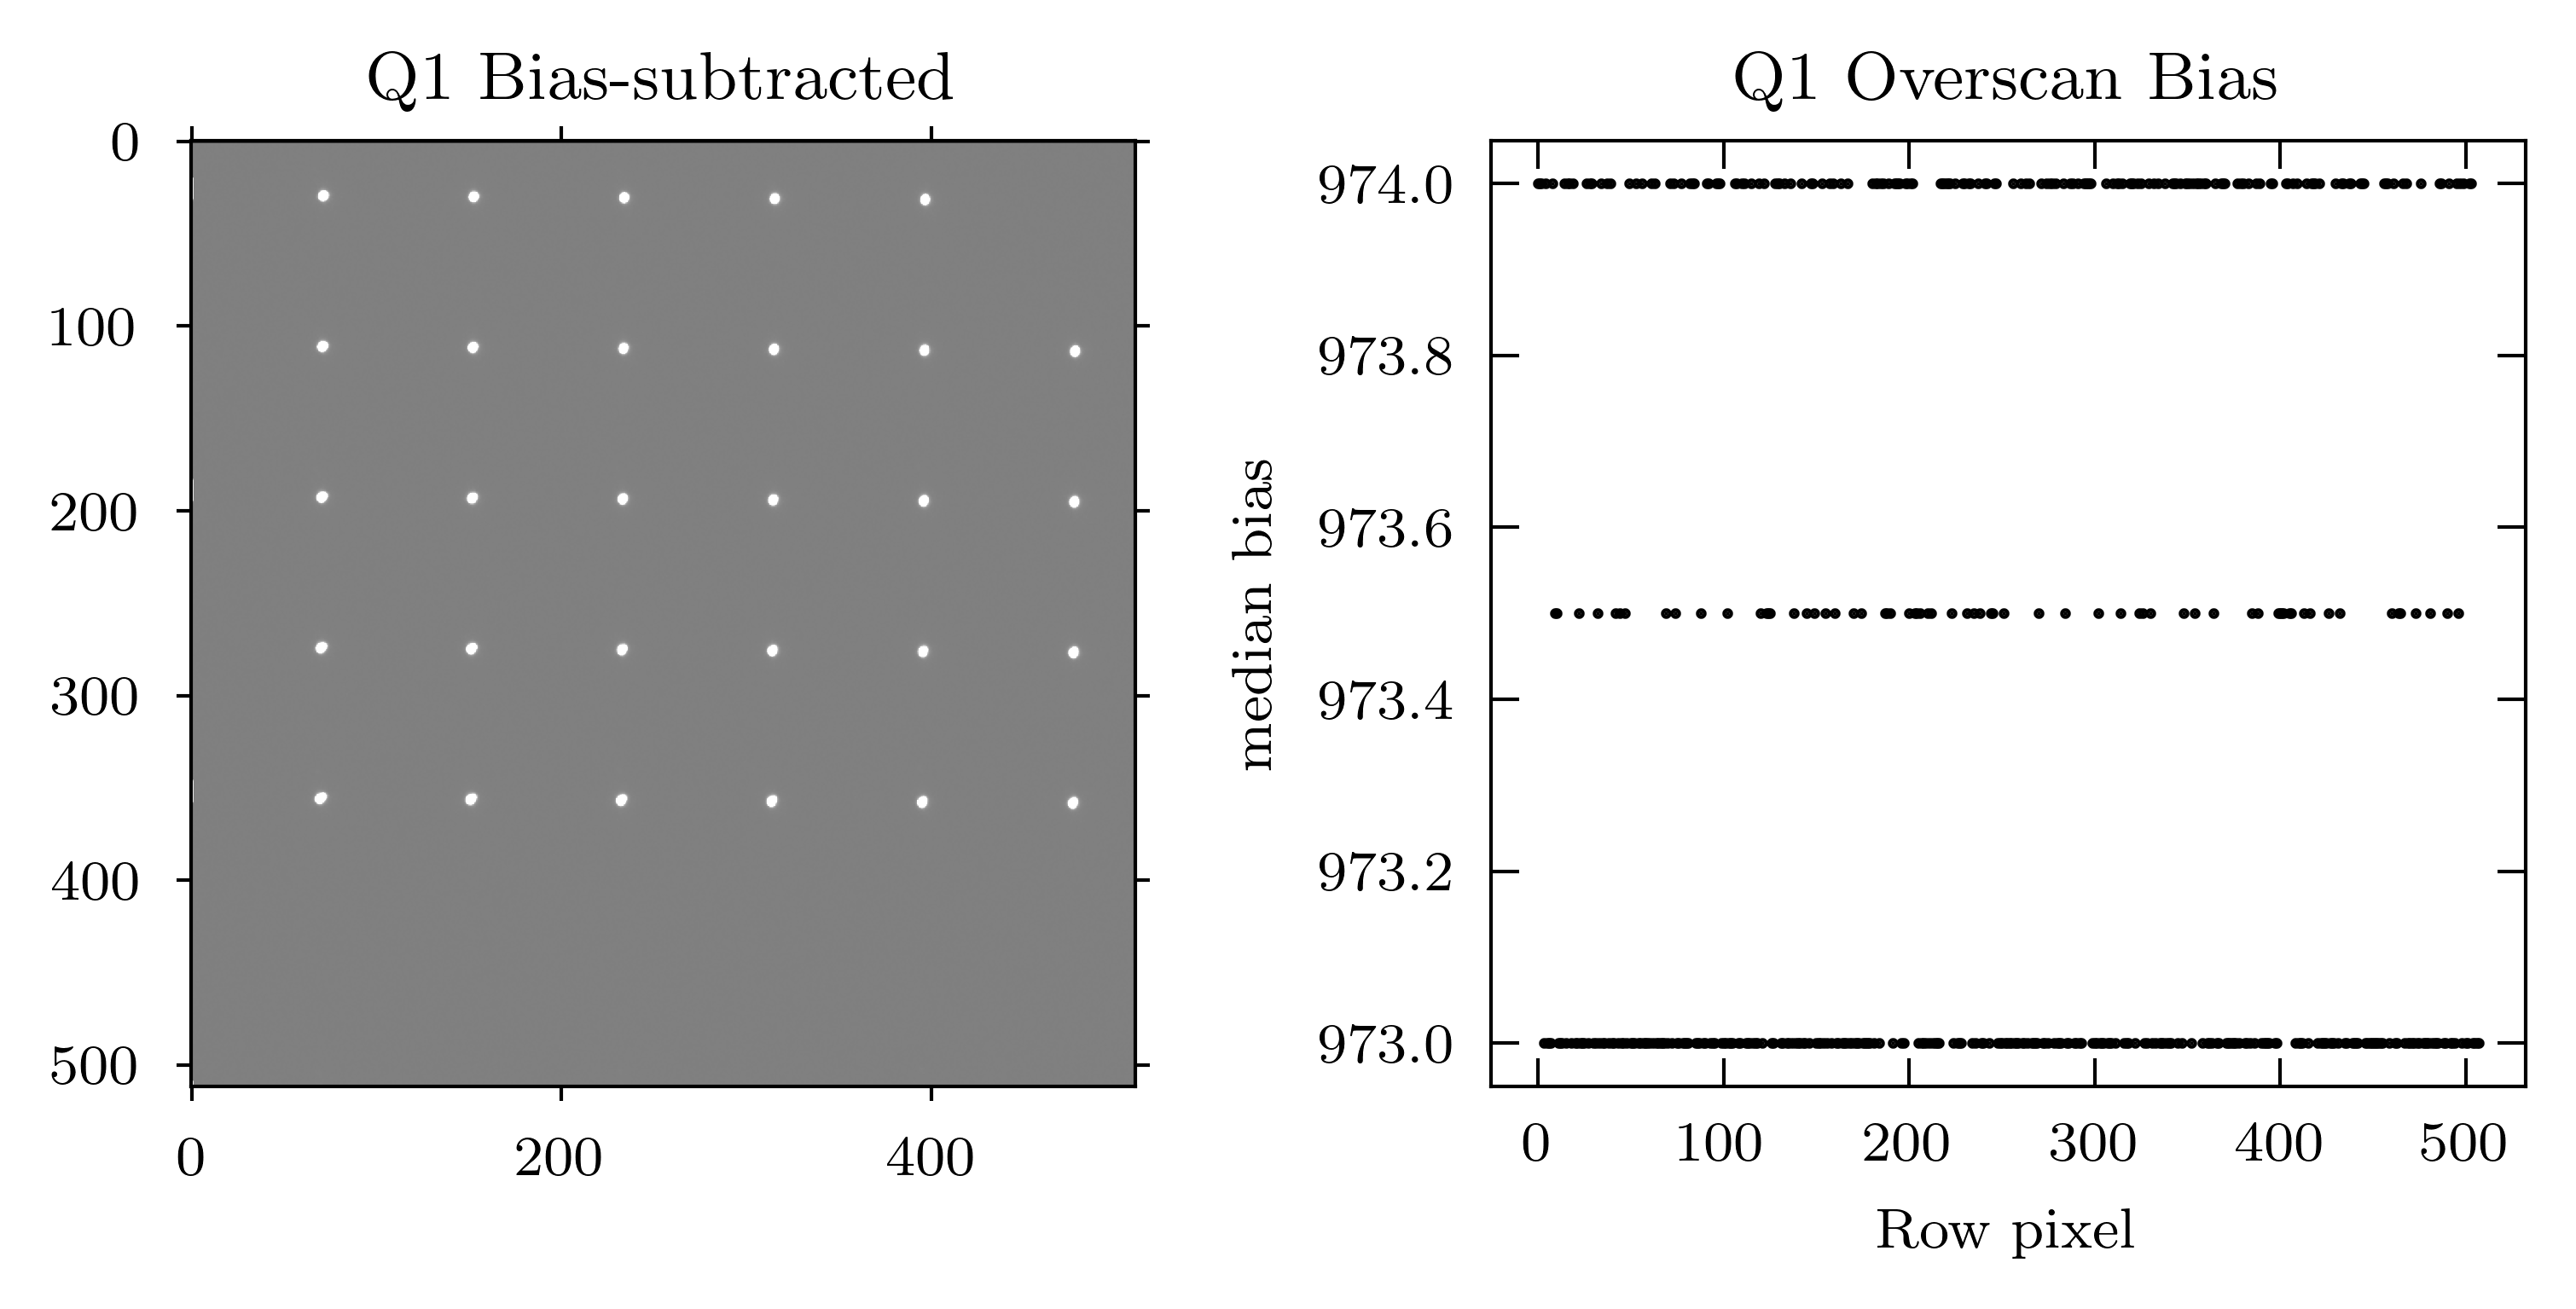


Image Q2:
  Format: 544x512, 32 overscan columns
  imgData shape: (512, 544)
  BIASSEC=[513:544,1:512]
  DATASEC=[1:512,1:512]
  DETSEC=[8288:7777,1033:1544]
  CCDSEC=[8288:7777,1033:1544]
   Min: 0.00
   Max: 26270.00
  Mean: 986.41, Median: 976.00
   Std: 408.84
  biasCols shape: (508, 30)
  Bias: Median=975.00 +/- 1.74, Min=967.00 Max=983.00
        clipped median: 975.00 +/- 0.48


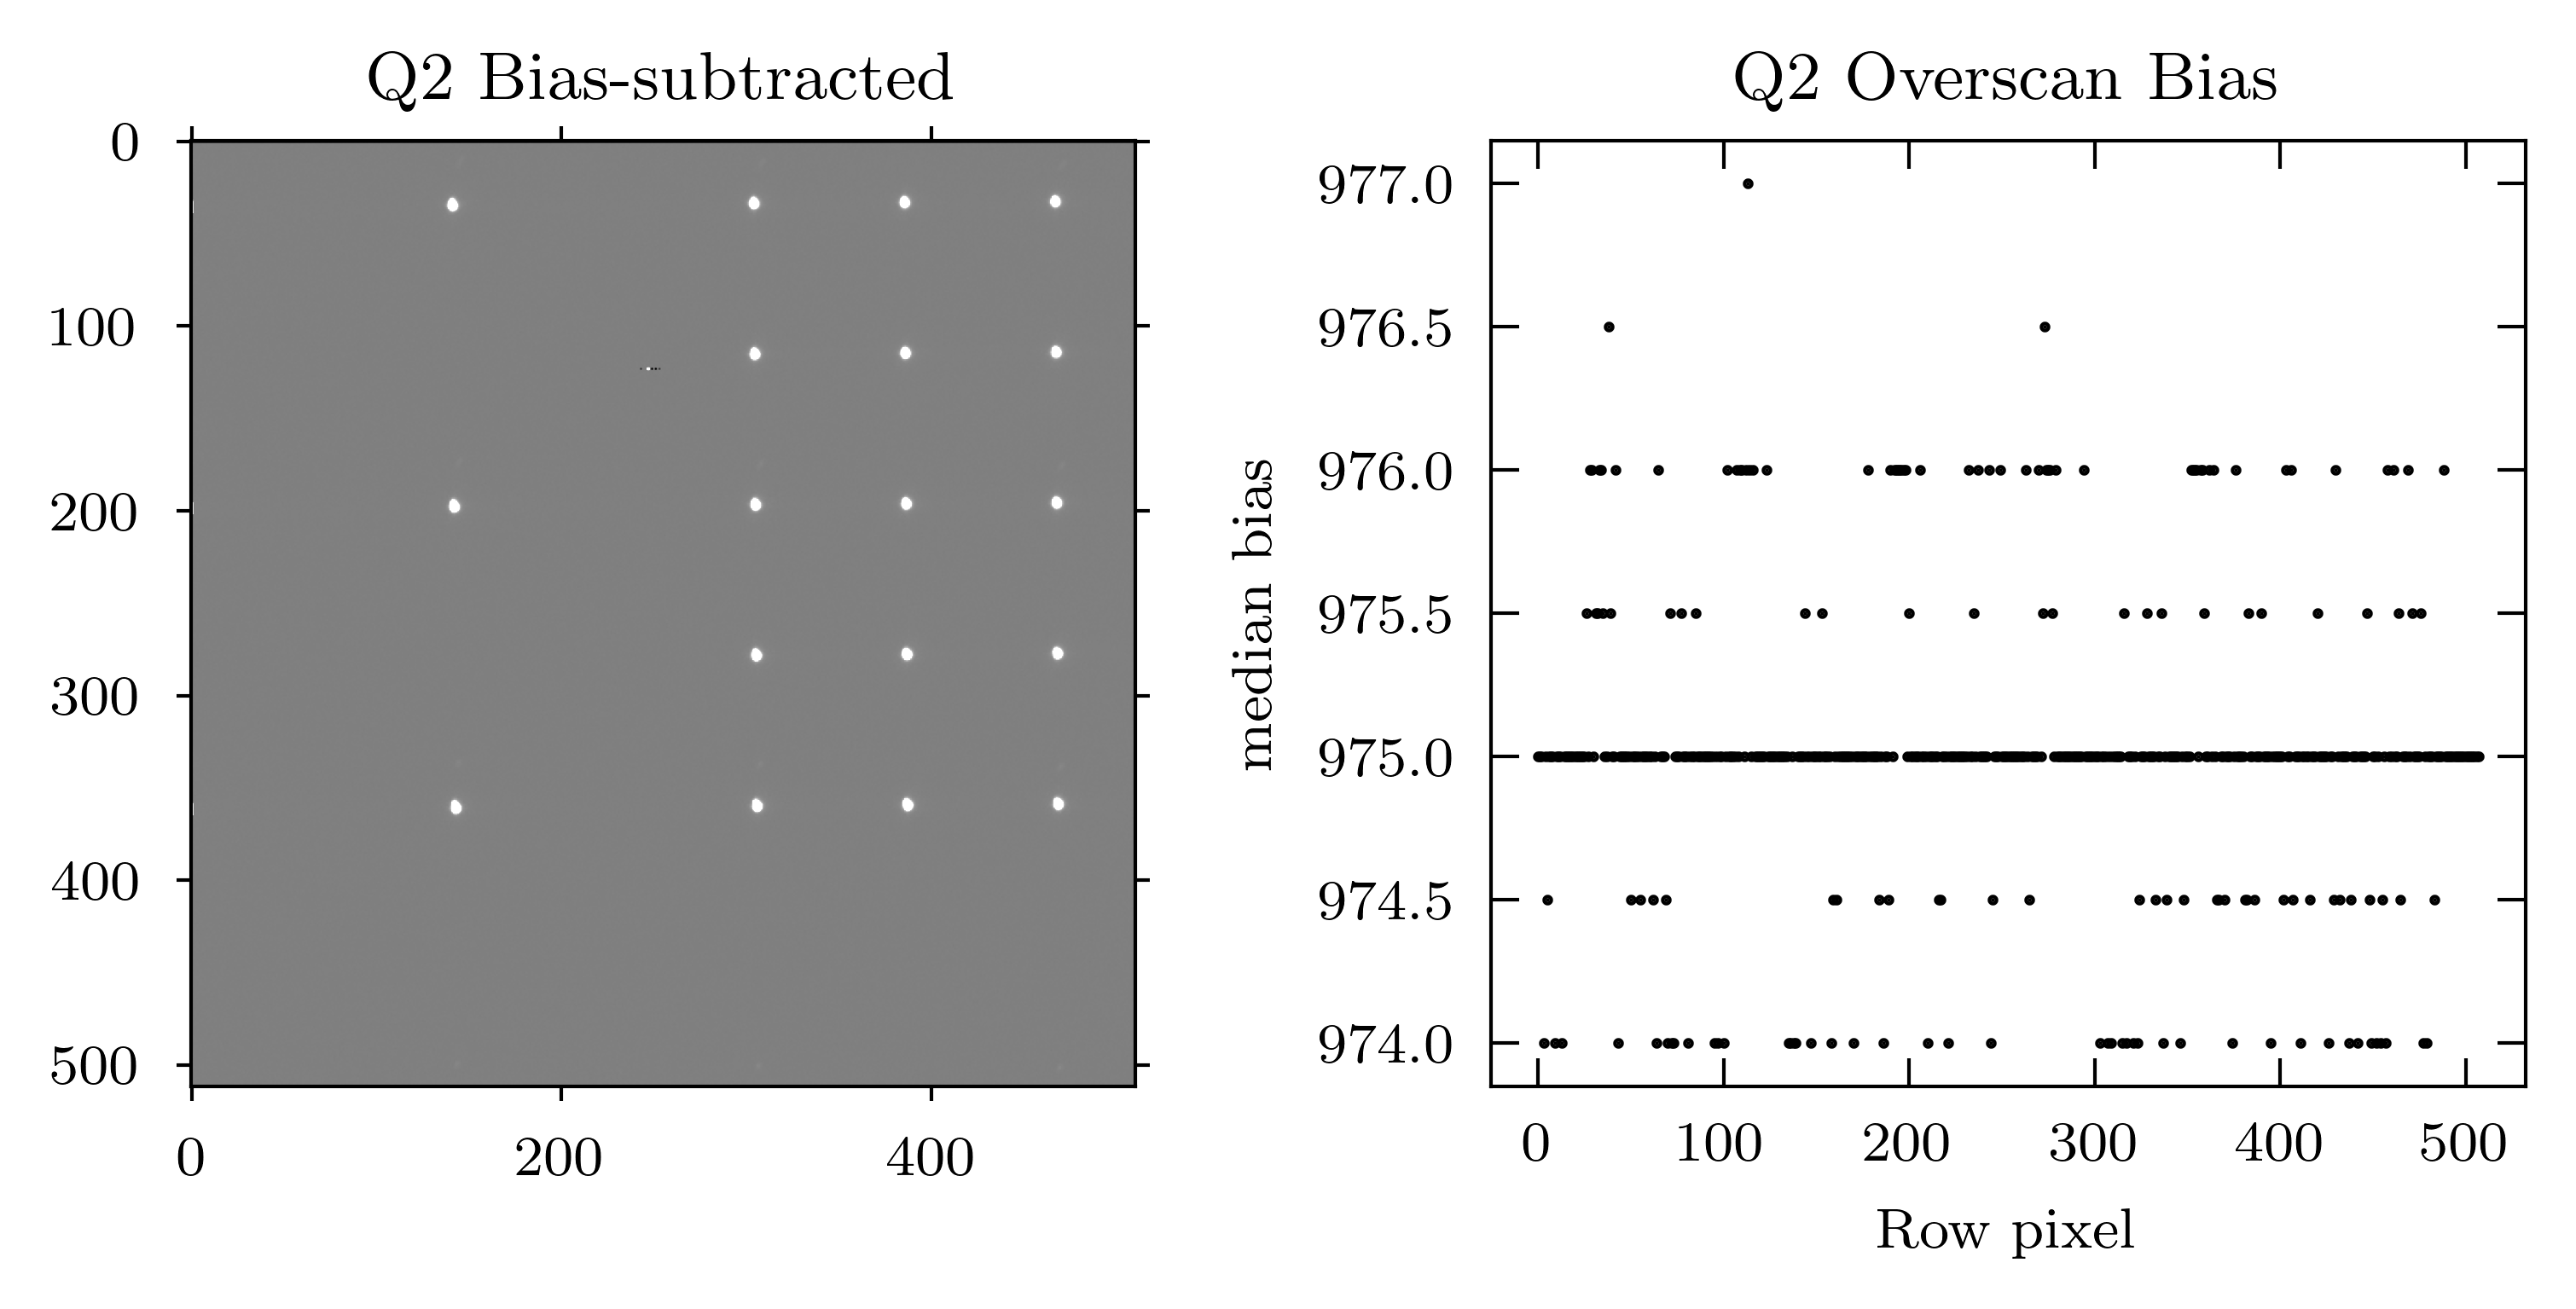


Image Q3:
  Format: 544x512, 32 overscan columns
  imgData shape: (512, 544)
  BIASSEC=[513:544,1:512]
  DATASEC=[1:512,1:512]
  DETSEC=[3633:4144,2577:3088]
  CCDSEC=[3633:4144,2577:3088]
   Min: 0.00
   Max: 27698.00
  Mean: 983.31, Median: 972.00
   Std: 414.13
  biasCols shape: (508, 30)
  Bias: Median=971.00 +/- 1.62, Min=964.00 Max=977.00
        clipped median: 971.00 +/- 0.45


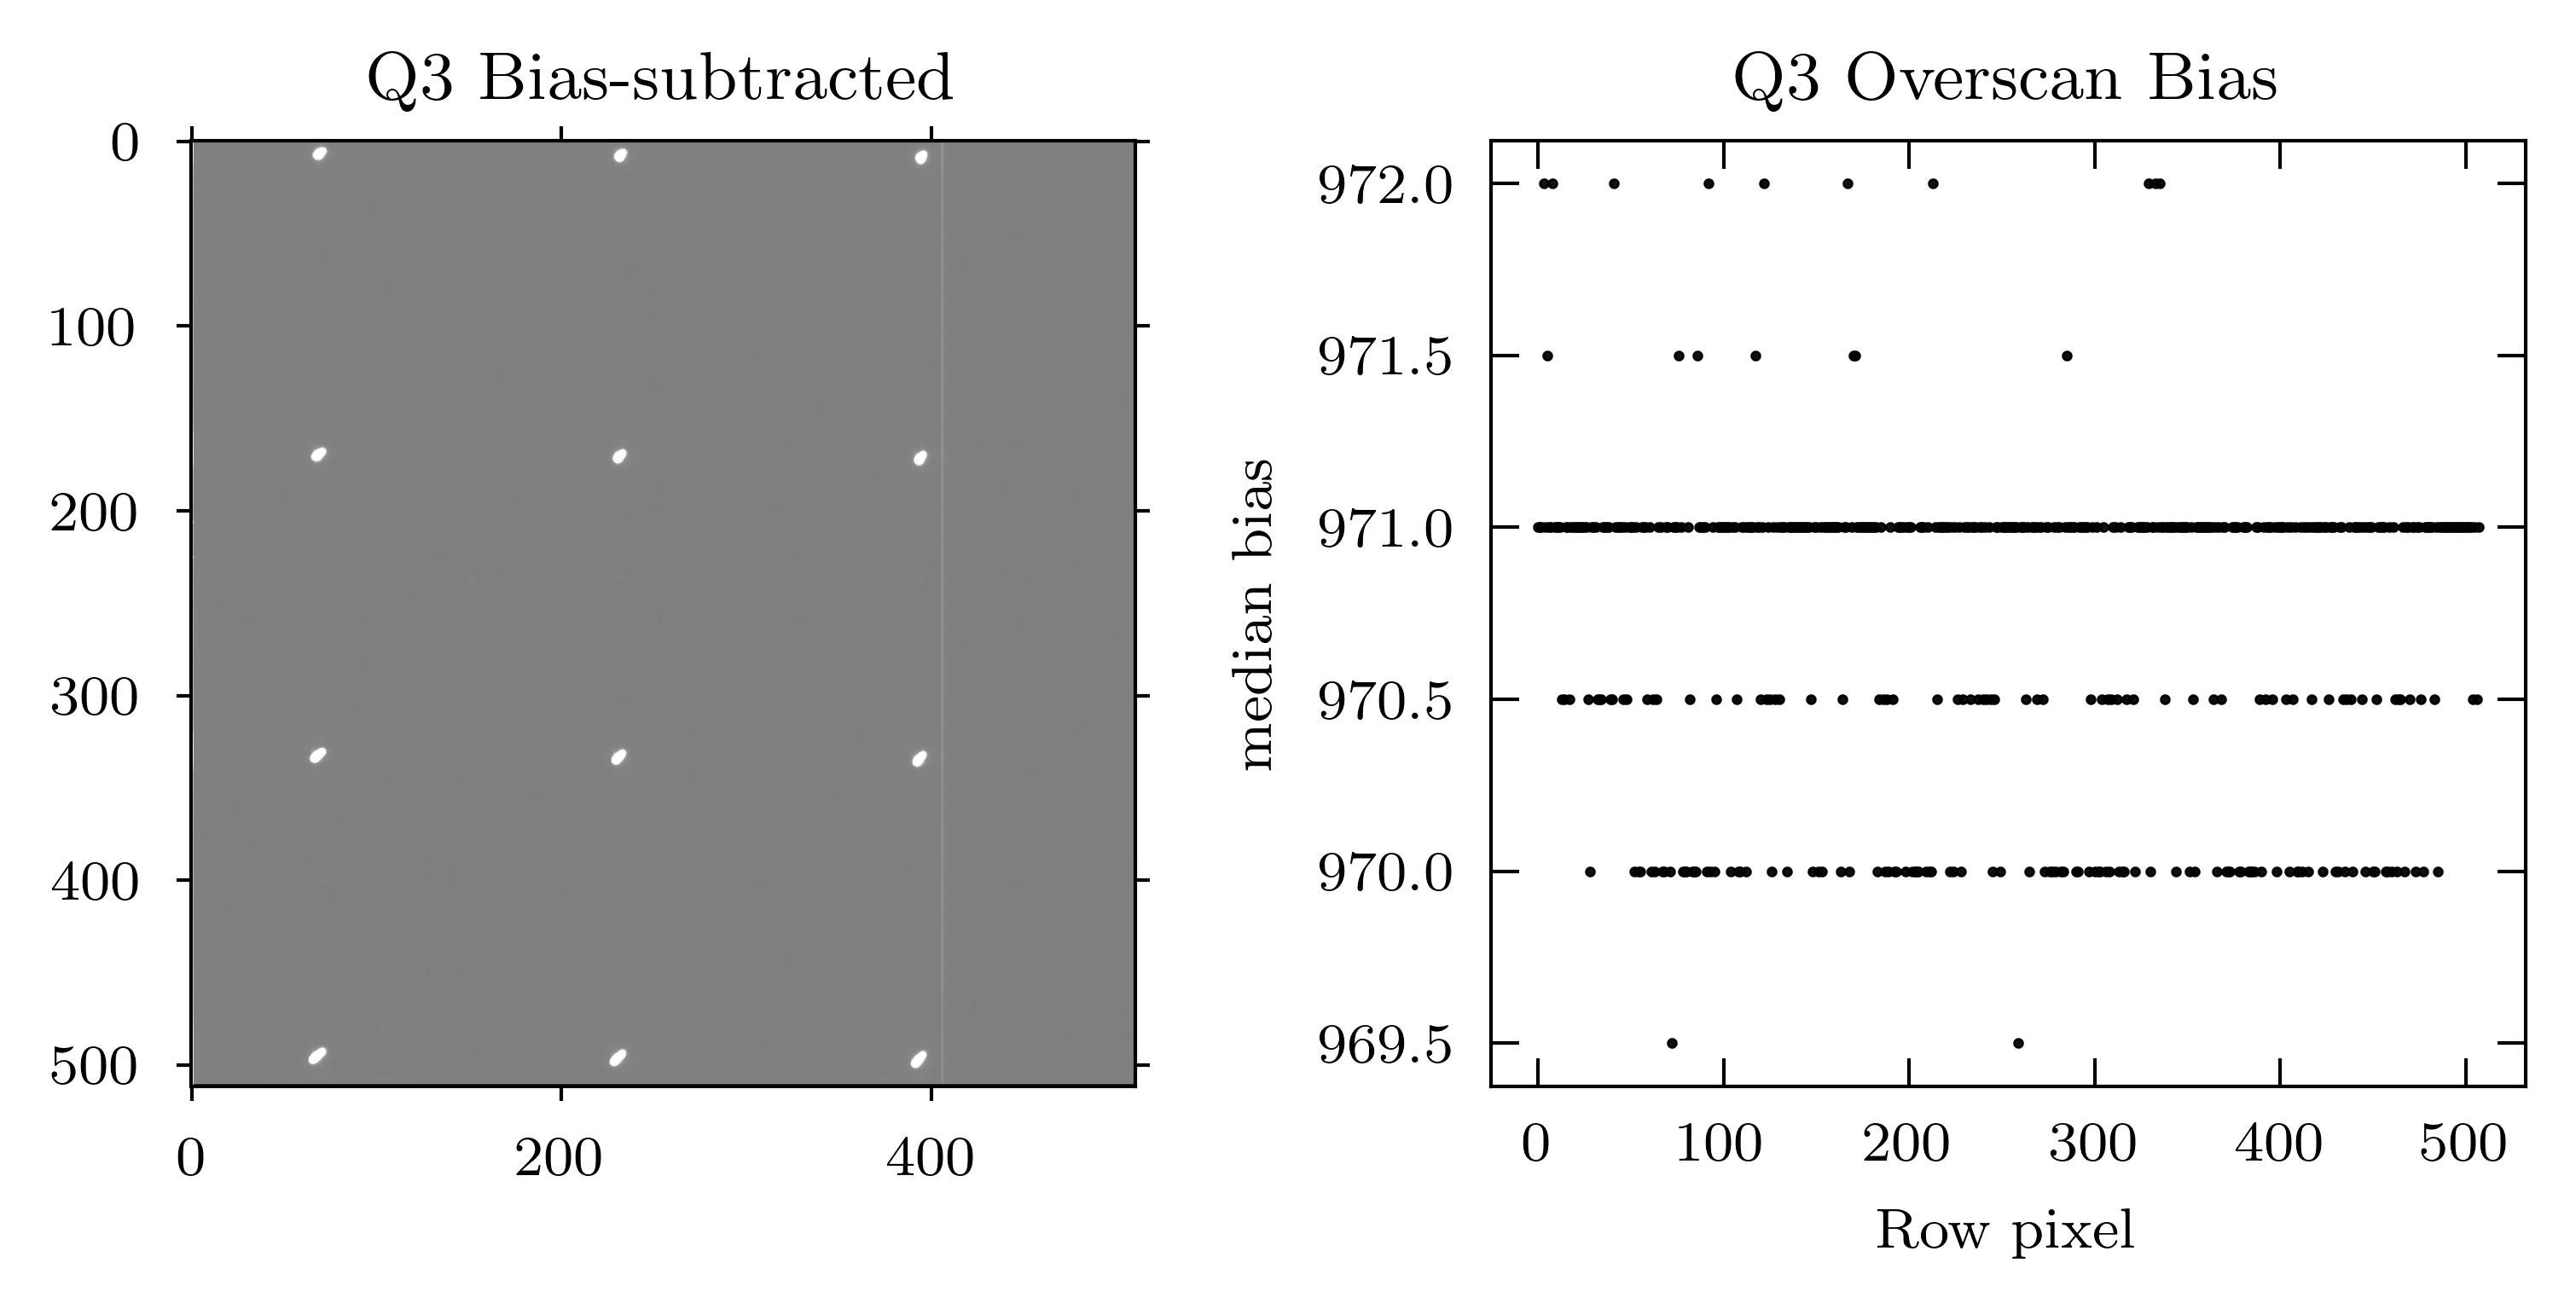


Image Q4:
  Format: 544x512, 32 overscan columns
  imgData shape: (512, 544)
  BIASSEC=[513:544,1:512]
  DATASEC=[1:512,1:512]
  DETSEC=[8288:7777,2577:3088]
  CCDSEC=[8288:7777,2577:3088]
   Min: 0.00
   Max: 28196.00
  Mean: 988.09, Median: 978.00
   Std: 420.39
  biasCols shape: (508, 30)
  Bias: Median=977.00 +/- 1.62, Min=970.00 Max=984.00
        clipped median: 977.50 +/- 0.47


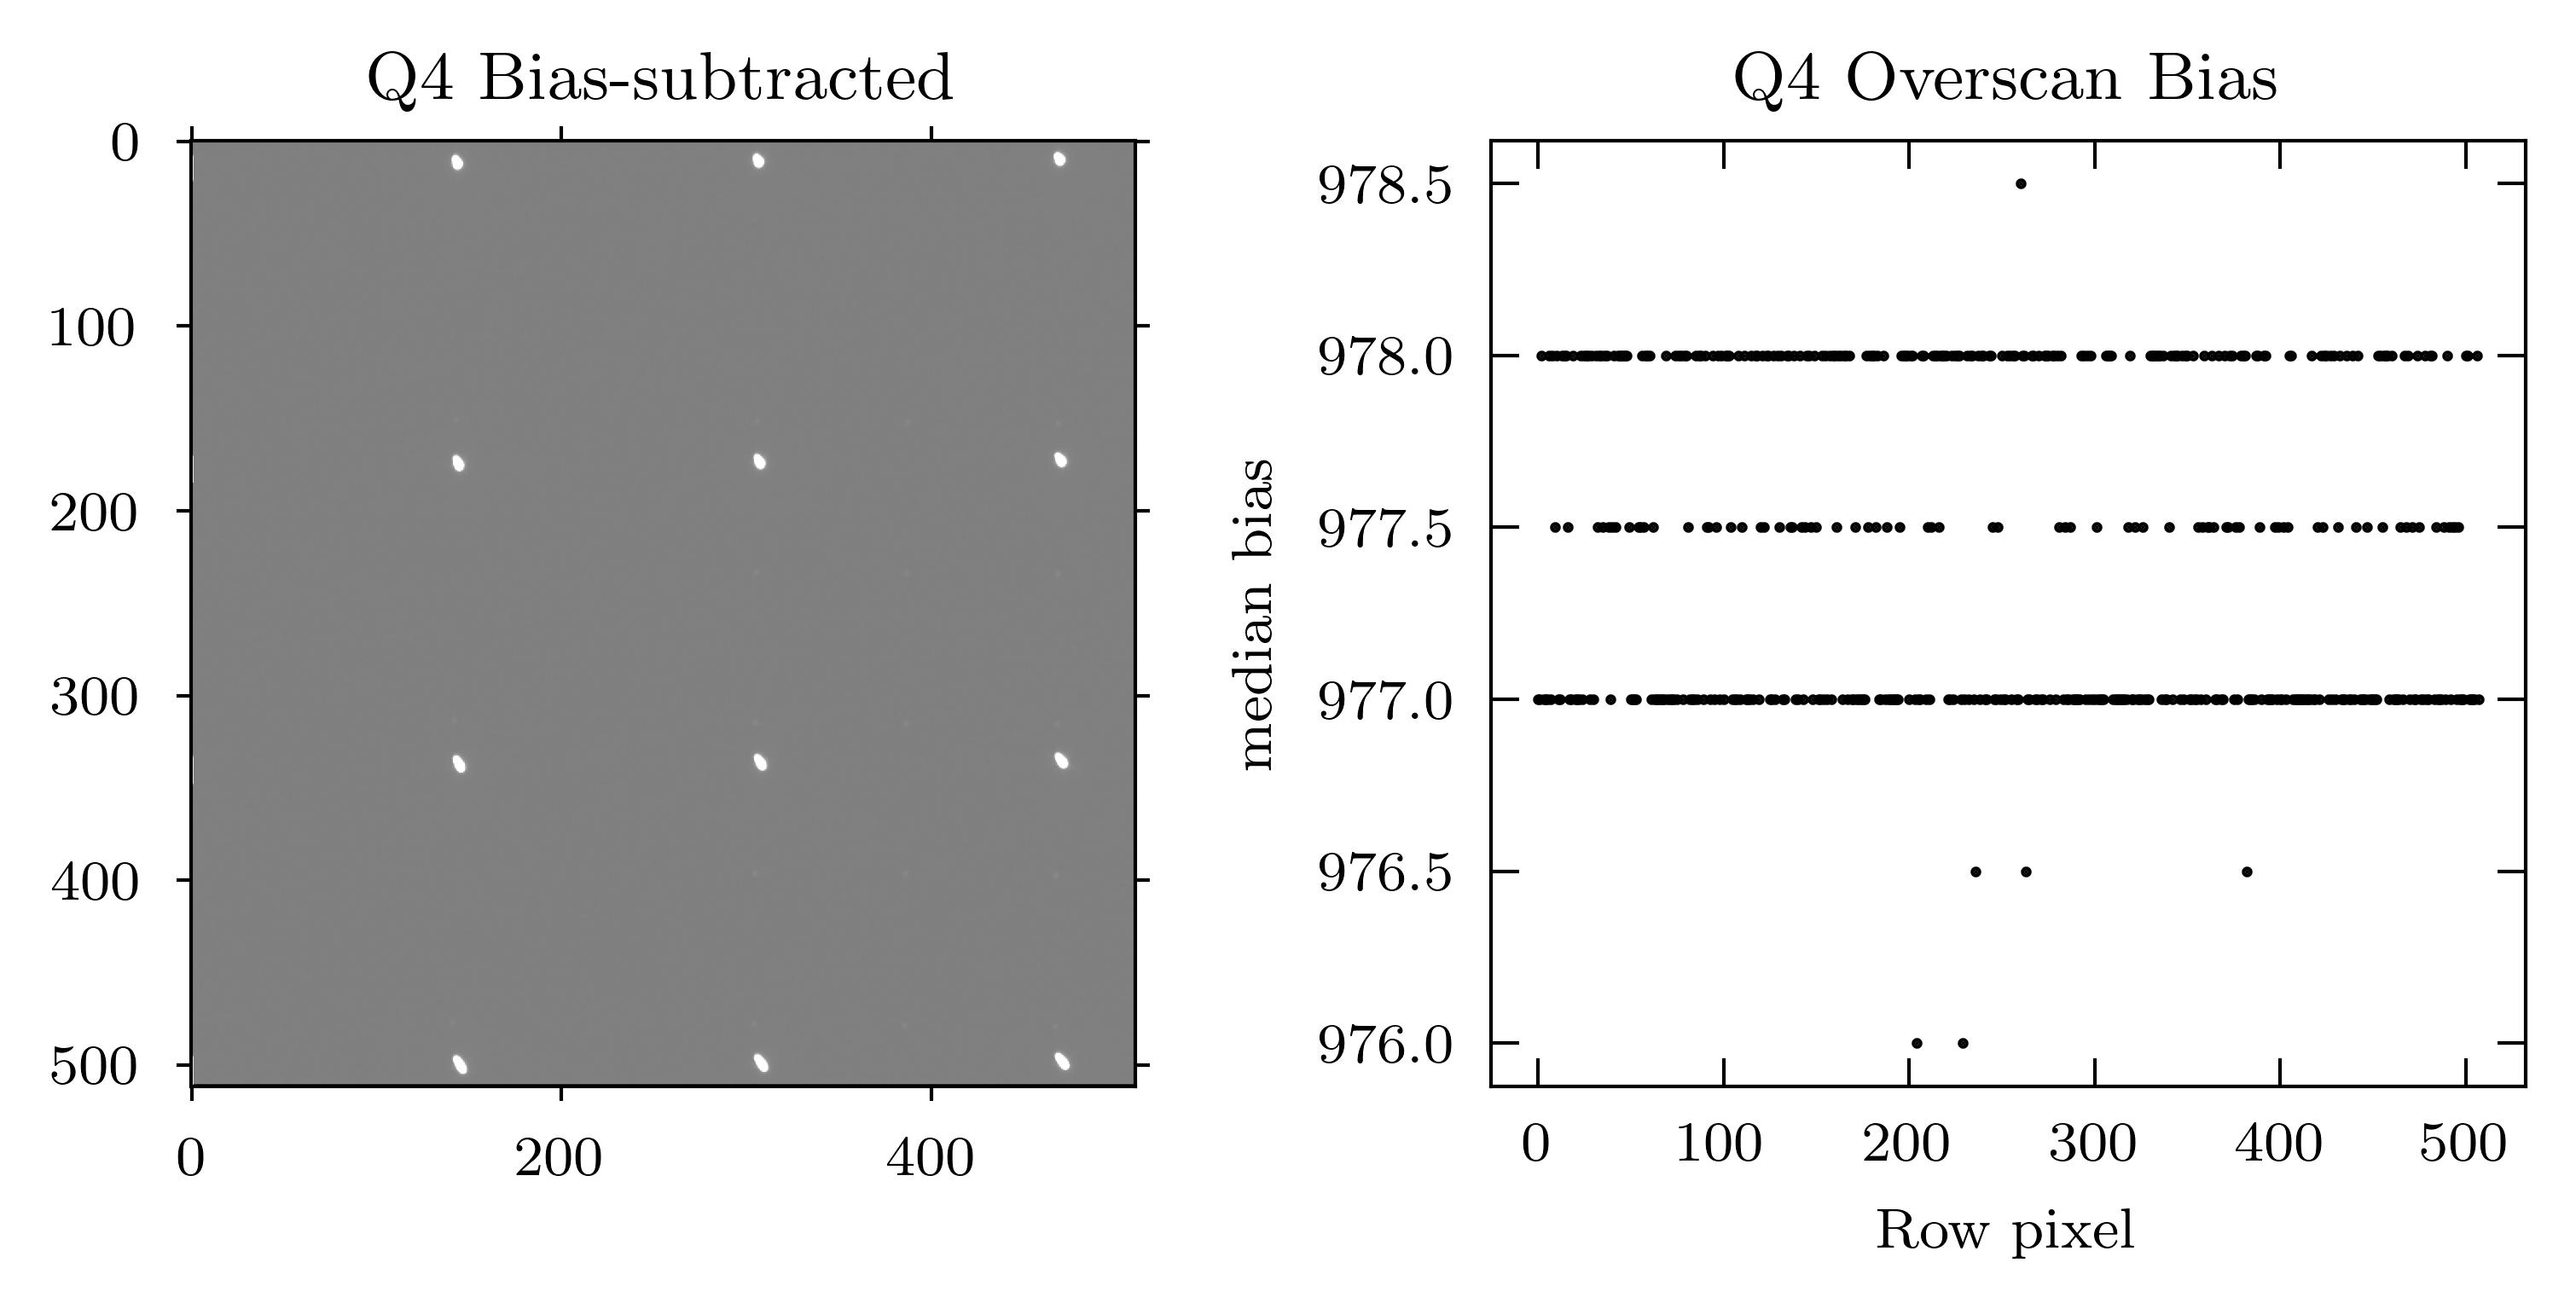

In [177]:
# plotting options

showOverscan = False

# reference pixels in x and y

xref = int(hdu[0].header["ref-pix1"])
yref = int(hdu[0].header["ref-pix2"])

print(f"Reference pixel: {xref},{yref}")

# quadrant

for quad in [1,2,3,4]:
    imgData = hdu[quad].data
    nc = hdu[quad].header['naxis1'] # number of columns
    nr = hdu[quad].header['naxis2'] # number of rows
    ncbias = hdu[quad].header['ovrscan1'] # number of overscan columns
    print(f"\nImage Q{quad}:")
    print(f"  Format: {nc}x{nr}, {ncbias} overscan columns")
    print(f"  imgData shape: {imgData.shape}")
    print(f"  BIASSEC={hdu[quad].header['biassec']}")
    print(f"  DATASEC={hdu[quad].header['datasec']}")
    print(f"  DETSEC={hdu[quad].header['detsec']}")
    print(f"  CCDSEC={hdu[quad].header['ccdsec']}")
    imgMed = np.median(imgData[:,:nc-ncbias-1])
    imgStd = np.std(imgData[:,:nc-ncbias-1])
    print(f"   Min: {np.min(imgData[:,:nc-ncbias-1]):.2f}")
    print(f"   Max: {np.max(imgData[:,:nc-ncbias-1]):.2f}")
    print(f"  Mean: {np.mean(imgData[:,:nc-ncbias-1]):.2f}, Median: {imgMed:.2f}")
    print(f"   Std: {imgStd:.2f}")

    biasColOff = 2
    biasRowOff = 2
    biasCols = imgData[biasRowOff:-biasRowOff,nc-ncbias+biasColOff:]
    print(f"  biasCols shape: {biasCols.shape}")
    medBias = np.median(biasCols)
    sigBias = np.std(biasCols)
    minBias = np.min(biasCols)
    maxBias = np.max(biasCols)
    print(f"  Bias: Median={medBias:.2f} +/- {sigBias:.2f}, Min={minBias:.2f} Max={maxBias:.2f}")

    bias1d = np.median(biasCols,axis=1)
    print(f"        clipped median: {np.median(bias1d):.2f} +/- {np.std(bias1d):.2f}")

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(wInches,hInches),dpi=dpi)
    fig.subplots_adjust(wspace=0.3, hspace=0.0)
    
    if showOverscan:
        ax1.imshow(imgData-medBias, cmap="gray",vmin=imgMed-medBias-imgStd,vmax=imgMed-medBias+imgStd)
    else:
        ax1.imshow(imgData[:,:nc-ncbias-1]-medBias, cmap="gray",vmin=imgMed-medBias-imgStd,vmax=imgMed-medBias+imgStd)
    ax1.tick_params('both',length=2,width=lwidth,which='major',direction='out',top='on',right='on')
    ax1.tick_params('both',length=1,width=lwidth,which='minor',direction='out',top='on',right='on')
    ax1.set_title(f"Q{quad} Bias-subtracted")
    
    ax2.tick_params('both',length=4,width=lwidth,which='major',direction='in',top='on',right='on')
    ax2.tick_params('both',length=2,width=lwidth,which='minor',direction='in',top='on',right='on')
    ax2.plot(bias1d,'.',lw=0.5,ms=1,color='black')
    ax2.set_xlabel("Row pixel")
    ax2.set_ylabel("median bias")
    ax2.set_title(f"Q{quad} Overscan Bias")

    plt.show()